# Stochastic and Deterministic Noise as Catalysts for Overfitting

Small exercise for showcasing the sources of overfitting. Example taken from the 4th Chapter of the book by Abu-Mostafa Yaser, [Learning from data](http://amlbook.com/).

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

# Set-up of the problem

The goal of the problem is to showcase the role stochastic and deterministic noise play in overfitting. 

To this end we are giong to fit polynomials to estimate a polynomial target function. We are going to use Legendre polynomials---an easy-to-handle orthonormal basis on $[-1, 1]$.

The input space is $\mathcal{X} = [-1, 1]$ with uniform probability density.

The target is a degree-$Q_f$ polynomial given by $f(x) = \sum_{q=0}^{Q_f} a_q L_q$ 

The coefficients are drawn from a rescaled standard normal distribution. We are rescaling the coefficients in order to keep the signal level fixed in expectation, so when we are changing the noise it has a one-to-one effect on the signal-noise ratio.

The rescaling makes use of the closed form expectation we can derive in case of Legendre polynomials and uniform distribution.

\begin{equation}
\mathbb{E}_{a,x} \big[ \ f^2\big ] = \sigma_{a}^2 \Bigg[1 + \frac{1}{3} + \frac{1}{5} + \ldots + \frac{1}{2Q_f + 1}\Bigg] = C
\end{equation}


The data set is $\mathcal{D} = \big\{ (x_1,y_1), \ldots, (x_N,y_N)\big\}$ where $y_n = f(x_n) + \sigma \epsilon_n$ and the $\epsilon_n$ are iid standard normal random variables. $\sigma$ defines the noise level in the problem.

# Generating the data

The following function generates a random target function of degree $Q_f$ and generates a noisy sample of size $N$ with added mean zero, $\sigma$ standard deviation noise.

In [5]:
def overfit_data(Qf, N, sig):
    """Generates a random sample of size N from polynomial function
    of degree Qf with added zero mean, sig s.d. normal noise."""

    # Draw randmom coefficients from rescaled standard normal so that signal level is constant.
    sigma_signal = 2/np.sqrt(sum([1/(2*q + 1) for q in range(Qf)]))
    a = np.random.normal(0, sigma_signal, Qf+1)
    
    # Generate random input sample and noise
    x = np.random.uniform(-1, 1, N)                # generate a sample of input vectors
    eps = np.random.normal(0, sig, N)              # generate a sample of random noise
    
    # Generate dependent variable with Legendre poly, and noise
    y = np.polynomial.legendre.legval(x, a) + eps
    return x, y, a

# Estimates for in-sample and out-of-sample errors


Taking a given target function with coefficients $a$, the following function computes estimates for the in-sample and out-of-sample errors.

For this end it generates 'num_exper' many experiments with training and test samples of size $N$ fits a 2nd and 10th degree polynomial. Then computes the corresponding errors.

In [6]:
def error(a, N, sig, num_exper):
    """Generates many samples for a given target function with parameters 'a'
    and computes estimates for in- and out-of-sample errors."""
    
    E_in_2 =  np.zeros(num_exper)  # in-sample error for 2nd degree fit
    E_out_2 = np.zeros(num_exper)  # out-of-sample error for 2nd degree fit
    E_in_10 =  np.zeros(num_exper) # in-sample error for 10th degree fit
    E_out_10 = np.zeros(num_exper) # ou-of-sample error for 10th degree fit
    
    for i in range(num_exper):
        
        # Generate sample from specified target function
        x = np.random.uniform(-1, 1, 2*N)
        eps = np.random.normal(0, sig, 2*N)
        y = np.polynomial.legendre.legval(x, a) + eps
        
        # Split sample to training and test set
        x_train = x[:N] 
        y_train = y[:N]
        x_test = x[N:] 
        y_test = y[N:]
        
        # Fit 2nd order polynomial to data
        fit2 = np.polynomial.legendre.legfit(x_train, y_train,2)
        E_in_2[i] =  np.mean((y_train - np.polynomial.legendre.legval(x_train, fit2))**2)
        E_out_2[i] = np.mean((y_test - np.polynomial.legendre.legval(x_test, fit2))**2)
        
        # Fit 10th order polynomial to data
        fit10 = np.polynomial.legendre.legfit(x_train,y_train,10)
        E_in_10[i] = np.mean((y_train - np.polynomial.legendre.legval(x_train, fit10))**2)
        E_out_10[i] = np.mean((y_test - np.polynomial.legendre.legval(x_test, fit10))**2)
    
    # Average over experiments to get estimate for the errors
    E_2 = np.array([np.mean(E_in_2), np.mean(E_out_2)])
    E_10 = np.array([np.mean(E_in_10), np.mean(E_out_10)])
    return E_2, E_10

# 10th order polynomial noisy target function

Generate small sample of noisy data from 10th degree polynomial target function and try and learn it with 3nd and 10th order polynomials.

In [38]:
np.random.seed(11211)

Qf = 10           # degree of target polynomial
N = 15            # sample size
sig = 1           # level of noise

# Generate data with specified parameters
x, y, a_10 = overfit_data(Qf, N, sig)
model = np.polynomial.legendre.Legendre(a_10) # save instance of Legendre class

# Fit 2nd order polynomial to data
fit2 = np.polynomial.legendre.legfit(x,y,2)
model_fit2 = np.polynomial.legendre.Legendre(fit2) # save instance of Legendre class

# Fit 10th order polynomial to data
fit10 = np.polynomial.legendre.legfit(x,y,10)
model_fit10 = np.polynomial.legendre.Legendre(fit10) # save instance of Legendre class

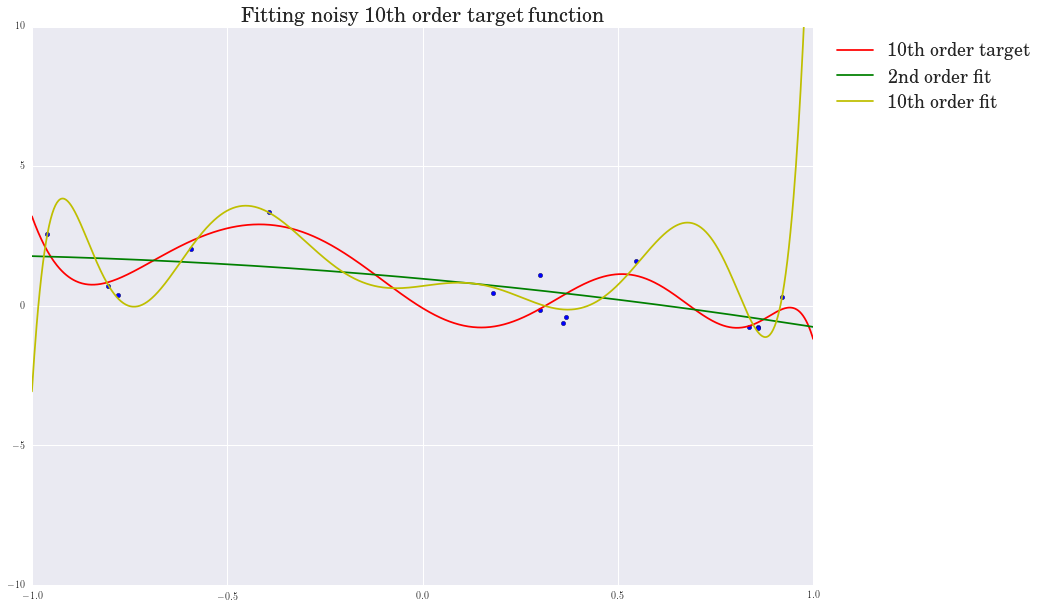

In [39]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(14, 10))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.ylim(-10,10)
plt.xlim(-1,1)
plt.scatter(x,y)
plt.plot(*model.linspace(1000), color='r', label='10th order target')
plt.plot(*model_fit2.linspace(1000), color='g', label='2nd order fit')
plt.plot(*model_fit10.linspace(1000), color='y', label='10th order fit')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, frameon=False, fontsize = 18)
plt.title('Fitting noisy 10th order target function', {'fontsize':20})
plt.show()

Below we can see averaged in-sample and out-of-sample error in the case of fitting a 10th order noisy target function from 2nd and 10th order hypothesis spaces.

In [40]:
num_exper = 100 # number oof experiments to average over the in- and out-of-sample errors

E_2, E_10 = error(a_10, N, sig, num_exper)

print('--------------------------------------------------')
print('               10th order noisy target            ')
print('--------------------------------------------------')
print('      |     2nd order            10th order       ')
print('--------------------------------------------------')
print('E_in  |      {:1.3f}               {:1.3f}        '.format(E_2[0], E_10[0]))
print('E_out |      {:1.3f}               {:.3e}         '.format(E_2[1], E_10[1]))
print('--------------------------------------------------')

--------------------------------------------------
               10th order noisy target            
--------------------------------------------------
      |     2nd order            10th order       
--------------------------------------------------
E_in  |      1.429               0.286        
E_out |      2.577               4.487e+09         
--------------------------------------------------


As expected the 10th order fit delivers small in-sample error, however performs terribly out-of-sample.

# Learning Curves

Since we were dealing with consistent estimation methods as the sample size increases the in- and out-of-sample errors should converge to the true risk within the corresponding hypothesis spaces. 

\begin{equation*}
R(\hat{f}_n) - R(f_{\mathcal{F}}) = \underbrace{R(\hat{f}_n) - R(f_{\mathcal{H}})}_{\text{estimation error}} \ + \ \underbrace{R(f_{\mathcal{H}}) - R(f_{\mathcal{F}})}_{\text{approximation error}}
\end{equation*}

## Learning Curve for learning the 10th order noisy target

In [43]:
N_start = 15
N_stop = 150
step = 2

num_steps = len(range(N_start, N_stop , step))

E_2 = np.zeros((2,num_steps))
E_10 = np.zeros((2,num_steps))
sample_size = np.zeros(num_steps)

for index, n in enumerate(range(N_start, N_stop , step)):
    E_2[:,index], E_10[:,index] =  error(a_10, n, 1, 2000)
    sample_size[index] = n

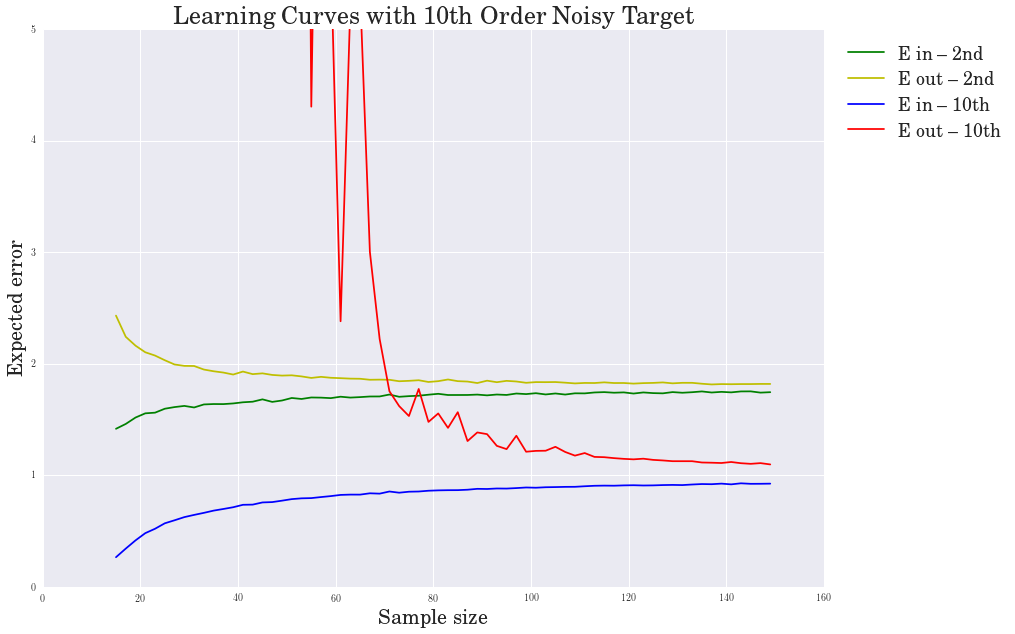

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')


plt.plot(sample_size, E_2[0], color='g', label='E in -- 2nd')
plt.plot(sample_size, E_2[1], color='y', label='E out -- 2nd')
plt.plot(sample_size, E_10[0], color='b', label='E in -- 10th')
plt.plot(sample_size, E_10[1], color='r', label='E out -- 10th')
plt.ylim(0,5)
plt.ylabel('Expected error', fontsize = 20)
plt.xlabel('Sample size', fontsize = 20)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, frameon=False, fontsize = 18)
plt.title('Learning Curves with 10th Order Noisy Target', {'fontsize':24})
plt.show()

We see how for smaller sample sizes the restricted learner---2nd degree---outperforms the one using the true 10th degree functional form.

Surprisingly, even if we know the form of the truth we are better off with restricting ourselves in finite samples in order to achieve better generalization.

# 50th order noiseless target

Let's see how the deterministic noise affects the performance of the different model.

In [11]:
np.random.seed(11206)


Qf = 50           # degree of target polynomial
N = 15            # sample size
sig = 0.001           # level of noise

# Generate data with specified parameters
x, y, a_50 = overfit_data(Qf, N, sig)
model = np.polynomial.legendre.Legendre(a_50)

# Fit 2nd order polynomial to data
fit2 = np.polynomial.legendre.legfit(x,y,2)
model_fit2 = np.polynomial.legendre.Legendre(fit2)

# Fit 10th order polynomial to data
fit10 = np.polynomial.legendre.legfit(x,y,10)
model_fit10 = np.polynomial.legendre.Legendre(fit10)

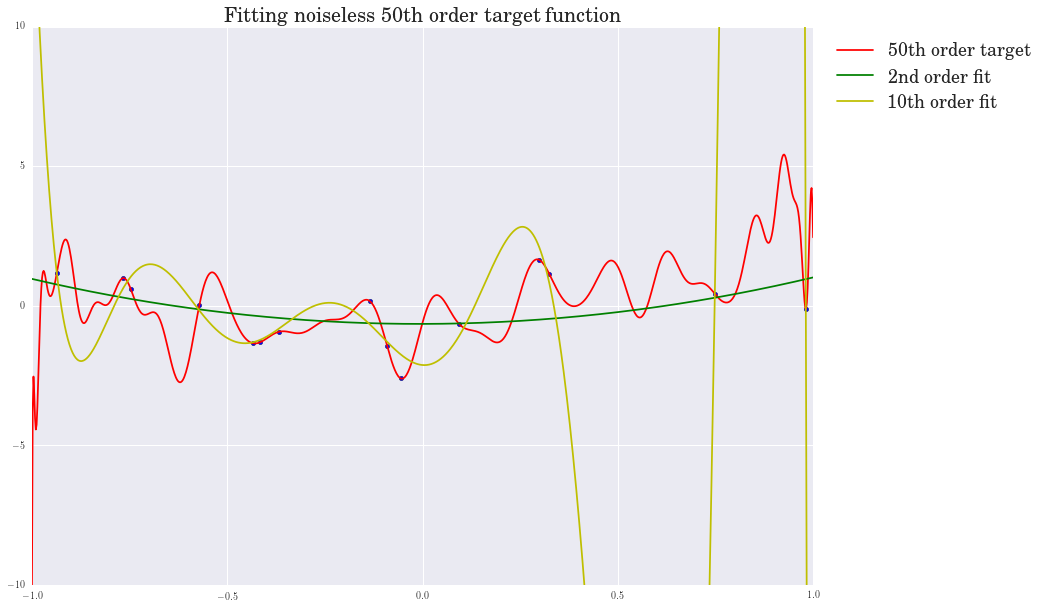

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.scatter(x,y)
plt.plot(*model.linspace(1000), color='r', label='50th order target')
plt.plot(*model_fit2.linspace(1000), color='g', label='2nd order fit')
plt.plot(*model_fit10.linspace(1000), color='y', label='10th order fit')
plt.ylim(-10,10)
plt.xlim(-1,1)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, frameon=False, fontsize = 18)
plt.title('Fitting noiseless 50th order target function', {'fontsize':20})
plt.show()

In [11]:
E_2, E_10 = error(a_50, N, sig, num_exper)

print('--------------------------------------------------')
print('            5oth order noiseless target           ')
print('--------------------------------------------------')
print('fit   |     2nd order            10th order       ')
print('--------------------------------------------------')
print('E_in  |      {:1.3f}               {:1.3f}        '.format(E_2[0], E_10[0]))
print('E_out |      {:1.3f}               {:.3e}         '.format(E_2[1], E_10[1]))
print('--------------------------------------------------')

--------------------------------------------------
            5oth order noiseless target           
--------------------------------------------------
fit   |     2nd order            10th order       
--------------------------------------------------
E_in  |      0.851               0.145        
E_out |      1.504               2.205e+11         
--------------------------------------------------


Again we see that the 10th order fit delivers better in-sample error on the expense of a terrible out-of-sample performance.

### Learning curve for learning the 50th order noiseless target

In [12]:
N_start = 15
N_stop = 150
step = 2

num_steps = len(range(N_start, N_stop , step))

E_2 = np.zeros((2,num_steps))
E_10 = np.zeros((2,num_steps))
sample_size = np.zeros(num_steps)

for index, n in enumerate(range(N_start, N_stop , step)):
    E_2[:,index], E_10[:,index] =  error(a_50, n, .001, 2000)
    sample_size[index] = n

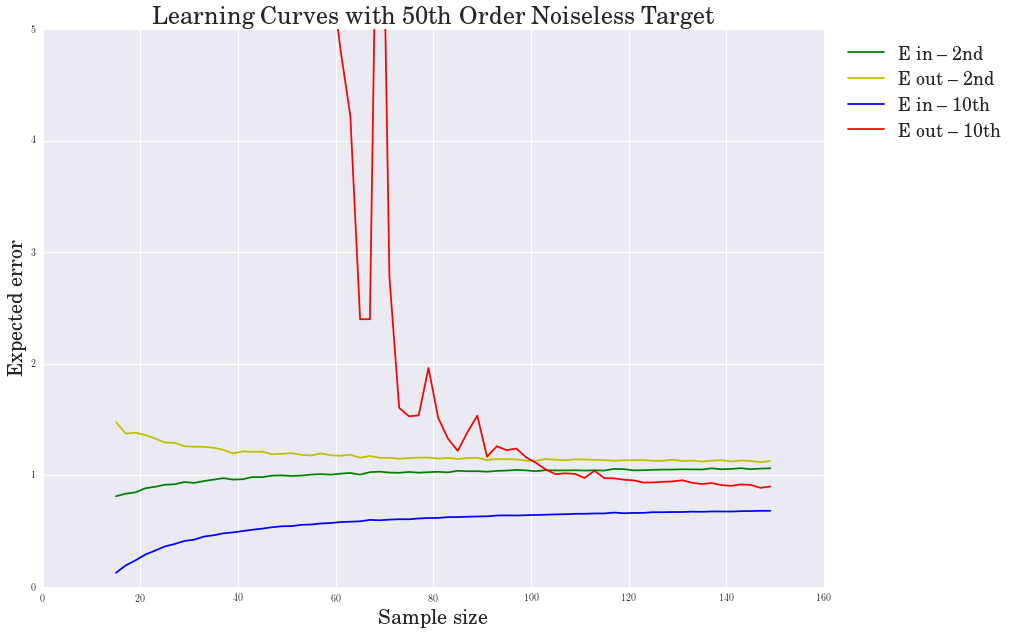

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')


plt.plot(sample_size, E_2[0], color='g', label='E in -- 2nd')
plt.plot(sample_size, E_2[1], color='y', label='E out -- 2nd')
plt.plot(sample_size, E_10[0], color='b', label='E in -- 10th')
plt.plot(sample_size, E_10[1], color='r', label='E out -- 10th')
plt.ylim(0,5)
plt.ylabel('Expected error', fontsize = 20)
plt.xlabel('Sample size', fontsize = 20)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, frameon=False, fontsize = 18)
plt.title('Learning Curves with 50th Order Noiseless Target', {'fontsize':24})
plt.show()